# Task
Fine-tune a Named Entity Recognition (NER) model using the provided Amharic CoNLL data to extract entities such as products and prices.

## Install necessary libraries

### Subtask:
Install `transformers`, `datasets`, and `seqeval` to facilitate the fine-tuning of a Named Entity Recognition (NER) model using Amharic CoNLL data.


**Reasoning**:
Install the necessary libraries for model fine-tuning and evaluation.



In [2]:
%pip install transformers datasets seqeval

## Load and prepare the dataset

### Subtask:
Load the CoNLL data and convert it into a suitable format for the `datasets` library.


**Reasoning**:
Load the CoNLL data, parse it into a suitable format, and convert it into `datasets.Dataset` objects as required by the subtask instructions.



In [3]:
import datasets
import os

def parse_conll_file(file_path):
    """Parses a CoNLL file into a list of dictionaries representing sentences."""
    sentences = []
    current_sentence = {"words": [], "ner_tags": []}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence["words"]:  # Add sentence if not empty
                    sentences.append(current_sentence)
                current_sentence = {"words": [], "ner_tags": []}
            else:
                parts = line.split()
                if len(parts) >= 2:  # Ensure line has at least word and tag
                    current_sentence["words"].append(parts[0])
                    current_sentence["ner_tags"].append(parts[1])
    # Add the last sentence if the file doesn't end with a blank line
    if current_sentence["words"]:
        sentences.append(current_sentence)
    return sentences

# Define file paths (replace with your actual file paths)
train_file = "amharic_ner_train.conll"
validation_file = "amharic_ner_validation.conll"
test_file = "amharic_ner_test.conll"

# Check if files exist, if not, create dummy files for demonstration
if not os.path.exists(train_file):
    with open(train_file, "w", encoding="utf-8") as f:
        f.write("ምርት O\nአፕል B-PRODUCT\nዋጋ B-PRICE\n500 I-PRICE\nብር O\n\n")
        f.write("ሌላ O\nምርት B-PRODUCT\nዋጋ B-PRICE\n1000 I-PRICE\n\n")

if not os.path.exists(validation_file):
    with open(validation_file, "w", encoding="utf-8") as f:
        f.write("አፕል B-PRODUCT\nዋጋ B-PRICE\n600 I-PRICE\nብር O\n\n")

if not os.path.exists(test_file):
    with open(test_file, "w", encoding="utf-8") as f:
        f.write("ሌላ O\nምርት B-PRODUCT\n\n")


# Load and parse the datasets
train_data = parse_conll_file(train_file)
validation_data = parse_conll_file(validation_file)
test_data = parse_conll_file(test_file)

# Convert to datasets.Dataset objects
train_dataset = datasets.Dataset.from_list(train_data)
validation_dataset = datasets.Dataset.from_list(validation_data)
test_dataset = datasets.Dataset.from_list(test_data)

# Display the first example from each dataset
print("Training dataset example:")
print(train_dataset[0])
print("\nValidation dataset example:")
print(validation_dataset[0])
print("\nTest dataset example:")
print(test_dataset[0])

Training dataset example:
{'words': ['ምርት', 'አፕል', 'ዋጋ', '500', 'ብር'], 'ner_tags': ['O', 'B-PRODUCT', 'B-PRICE', 'I-PRICE', 'O']}

Validation dataset example:
{'words': ['አፕል', 'ዋጋ', '600', 'ብር'], 'ner_tags': ['B-PRODUCT', 'B-PRICE', 'I-PRICE', 'O']}

Test dataset example:
{'words': ['ሌላ', 'ምርት'], 'ner_tags': ['O', 'B-PRODUCT']}


## Tokenize and align labels

### Subtask:
Tokenize the text and align the labels with the tokens.


**Reasoning**:
Define the tokenization and label alignment function, get unique tags and mappings, and apply the function to the datasets.



## Fine-tune the model

### Subtask:
Use the Hugging Face `Trainer` API to fine-tune the model.

**Reasoning**:
Define a data collator for padding, a function to compute evaluation metrics, and initialize the `Trainer` with the model, training arguments, datasets, tokenizer, data collator, and compute metrics function. Then, start the training.

 Load and Prepare the Dataset

In [4]:
import pandas as pd

def read_conll(filepath):
    sentences = []
    labels = []
    with open(filepath, encoding='utf-8') as f:
        words = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    labels.append(tags)
                    words = []
                    tags = []
            else:
                splits = line.split()
                if len(splits) == 2:
                    word, tag = splits
                    words.append(word)
                    tags.append(tag)
        if words:
            sentences.append(words)
            labels.append(tags)
    return sentences, labels

sentences, ner_tags = read_conll('/content/amharic_ner_labels_auto.conll')

Convert to Hugging Face Dataset

In [5]:
from datasets import Dataset

data = {'tokens': sentences, 'ner_tags': ner_tags}
dataset = Dataset.from_dict(data)
# Optionally split into train/validation
dataset = dataset.train_test_split(test_size=0.1)

In [6]:
unique_tags = set(tag for doc in ner_tags for tag in doc)
label2id = {tag: i for i, tag in enumerate(sorted(unique_tags))}
id2label = {i: tag for tag, i in label2id.items()}

Tokenize and Align Labels

In [7]:
from transformers import AutoTokenizer

model_checkpoint = "Davlan/afro-xlmr-base"  # Replace with your preferred model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",

    logging_strategy="epoch",  # <-- Add this line
    # OR, for more frequent logging:
    # logging_strategy="steps",
    # logging_steps=1,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # Log at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,

    compute_metrics=compute_metrics
)

/tmp/ipython-input-16-2818689180.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch", # Changed save_strategy to match eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [17]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [24]:
import numpy as np
from transformers import DataCollatorForTokenClassification
from datasets import load_metric

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (where label == -100)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id2label[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

/tmp/ipython-input-24-3666934473.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


#Train the Model


In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

/tmp/ipython-input-25-1612721487.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.400400,1.029637,0.000000,0.000000,0.000000,0.952941
2,0.818800,0.520365,0.000000,0.000000,0.000000,0.952941
3,0.474300,0.322667,0.000000,0.000000,0.000000,0.952941


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

TrainOutput(global_step=18, training_loss=0.8978197574615479, metrics={'train_runtime': 785.8974, 'train_samples_per_second': 0.172, 'train_steps_per_second': 0.023, 'total_flos': 7812066284490.0, 'train_loss': 0.8978197574615479, 'epoch': 3.0})

Evaluate and Save the Model

In [26]:
trainer.evaluate()
trainer.save_model("/content/amharic-ner-model")

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from google.colab import files
!zip -r amharic-ner-model.zip /content/amharic-ner-model
files.download("amharic-ner-model.zip")

  adding: content/amharic-ner-model/ (stored 0%)
  adding: content/amharic-ner-model/special_tokens_map.json (deflated 85%)
  adding: content/amharic-ner-model/training_args.bin (deflated 51%)
  adding: content/amharic-ner-model/model.safetensors (deflated 7%)
  adding: content/amharic-ner-model/tokenizer.json (deflated 76%)
  adding: content/amharic-ner-model/tokenizer_config.json (deflated 76%)
  adding: content/amharic-ner-model/sentencepiece.bpe.model (deflated 49%)
  adding: content/amharic-ner-model/config.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Task 4: Model Comparison & Selection

In [28]:
!pip install transformers datasets seqeval torch accelerate
!pip install wandb  # for experiment tracking

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 567.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# Models to compare for Amharic NER

In [2]:
# Models to compare for Amharic NER
MODELS_TO_COMPARE = {
    "xlm-roberta-base": {
        "name": "XLM-RoBERTa Base",
        "checkpoint": "xlm-roberta-base",
        "description": "Large multilingual model, good for NER tasks"
    },
    "afro-xlmr-base": {
        "name": "Afro-XLM-R Base",
        "checkpoint": "Davlan/afro-xlmr-base",
        "description": "Specialized for African languages including Amharic"
    },
    "bert-base-multilingual-cased": {
        "name": "mBERT",
        "checkpoint": "bert-base-multilingual-cased",
        "description": "Multilingual BERT, widely used for NER"
    },
    "distilbert-base-multilingual-cased": {
        "name": "DistilBERT Multilingual",
        "checkpoint": "distilbert-base-multilingual-cased",
        "description": "Smaller, faster version of mBERT"
    }
}

#Data Preparation Functions

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import load_metric
import time
import torch
from collections import Counter

def read_conll(filepath):
    """Read CoNLL format data"""
    sentences = []
    labels = []
    with open(filepath, encoding='utf-8') as f:
        words = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    labels.append(tags)
                    words = []
                    tags = []
            else:
                splits = line.split()
                if len(splits) == 2:
                    word, tag = splits
                    words.append(word)
                    tags.append(tag)
        if words:
            sentences.append(words)
            labels.append(tags)
    return sentences, labels

def prepare_dataset(sentences, ner_tags, test_size=0.2):
    """Prepare dataset for training"""
    data = {'tokens': sentences, 'ner_tags': ner_tags}
    dataset = Dataset.from_dict(data)
    dataset = dataset.train_test_split(test_size=test_size, seed=42)
    return dataset

def get_label_mapping(ner_tags):
    """Get label to ID mapping"""
    unique_tags = set(tag for doc in ner_tags for tag in doc)
    label2id = {tag: i for i, tag in enumerate(sorted(unique_tags))}
    id2label = {i: tag for tag, i in label2id.items()}
    return label2id, id2label

#Model Training and Evaluation Class

In [4]:
class ModelComparator:
    def __init__(self, dataset, label2id, id2label):
        self.dataset = dataset
        self.label2id = label2id
        self.id2label = id2label
        self.results = {}

    def tokenize_and_align_labels(self, examples, tokenizer):
        """Tokenize and align labels with tokens"""
        tokenized_inputs = tokenizer(
            examples["tokens"],
            truncation=True,
            is_split_into_words=True,
            max_length=512
        )
        labels = []
        for i, label in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            label_ids = []
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(self.label2id[label[word_idx]])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    def compute_metrics(self, p):
        """Compute evaluation metrics"""
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        true_predictions = [
            [self.id2label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [self.id2label[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        results = self.metric.compute(predictions=true_predictions, references=true_labels)
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

    def train_and_evaluate_model(self, model_config):
        """Train and evaluate a single model"""
        print(f"\n{'='*50}")
        print(f"Training {model_config['name']}")
        print(f"{'='*50}")

        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_config['checkpoint'])
        model = AutoModelForTokenClassification.from_pretrained(
            model_config['checkpoint'],
            num_labels=len(self.label2id),
            id2label=self.id2label,
            label2id=self.label2id
        )

        # Tokenize dataset
        tokenized_datasets = self.dataset.map(
            lambda x: self.tokenize_and_align_labels(x, tokenizer),
            batched=True
        )

        # Setup training arguments
        training_args = TrainingArguments(
            output_dir=f"./results_{model_config['checkpoint'].replace('/', '_')}",
            evaluation_strategy="epoch",
            logging_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            push_to_hub=False
        )

        # Setup data collator and metric
        data_collator = DataCollatorForTokenClassification(tokenizer)
        self.metric = load_metric("seqeval")

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics
        )

        # Train and evaluate
        start_time = time.time()
        train_result = trainer.train()
        training_time = time.time() - start_time

        # Evaluate
        eval_result = trainer.evaluate()

        # Measure inference speed
        start_time = time.time()
        trainer.predict(tokenized_datasets["test"])
        inference_time = time.time() - start_time

        # Store results
        self.results[model_config['name']] = {
            'model_name': model_config['name'],
            'checkpoint': model_config['checkpoint'],
            'description': model_config['description'],
            'training_time': training_time,
            'inference_time': inference_time,
            'eval_precision': eval_result['eval_precision'],
            'eval_recall': eval_result['eval_recall'],
            'eval_f1': eval_result['eval_f1'],
            'eval_accuracy': eval_result['eval_accuracy'],
            'train_loss': train_result.training_loss,
            'model_size_mb': sum(p.numel() for p in model.parameters()) / 1e6
        }

        print(f"✅ {model_config['name']} completed!")
        print(f"F1: {eval_result['eval_f1']:.4f}")
        print(f"Training time: {training_time:.2f}s")

        return self.results[model_config['name']]

# Load and prepare data

In [5]:
# Load and prepare data
sentences, ner_tags = read_conll('/content/amharic_ner_labels_auto.conll')
dataset = prepare_dataset(sentences, ner_tags)
label2id, id2label = get_label_mapping(ner_tags)

print(f"Dataset size: {len(sentences)} sentences")
print(f"Labels: {list(label2id.keys())}")
print(f"Label distribution: {Counter([tag for doc in ner_tags for tag in doc])}")

# Initialize comparator
comparator = ModelComparator(dataset, label2id, id2label)

# Train and evaluate all models
for model_key, model_config in MODELS_TO_COMPARE.items():
    try:
        result = comparator.train_and_evaluate_model(model_config)
    except Exception as e:
        print(f" Error with {model_config['name']}: {str(e)}")
        continue

Dataset size: 50 sentences
Labels: ['B-LOC', 'B-PRICE', 'B-Product', 'I-PRICE', 'O']
Label distribution: Counter({'O': 1040, 'B-PRICE': 36, 'B-Product': 14, 'B-LOC': 2, 'I-PRICE': 1})

Training XLM-RoBERTa Base


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3852159230.py:95: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric("seqeval")
/tmp/ipython-input-4-3852159230.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: ghiwot-tesfaye (ghiwot-tesfaye-gebby) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.538900,1.213385,0.000000,0.000000,0.000000,0.952381
2,1.000400,0.702689,0.000000,0.000000,0.000000,0.952381
3,0.606400,0.452846,0.000000,0.000000,0.000000,0.952381


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

✅ XLM-RoBERTa Base completed!
F1: 0.0000
Training time: 486.74s

Training Afro-XLM-R Base


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3852159230.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.324500,1.010638,0.000000,0.000000,0.000000,0.952381
2,0.851000,0.619688,0.000000,0.000000,0.000000,0.952381
3,0.560200,0.450349,0.000000,0.000000,0.000000,0.952381


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

✅ Afro-XLM-R Base completed!
F1: 0.0000
Training time: 510.53s

Training mBERT


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3852159230.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.702900,0.204269,0.000000,0.000000,0.000000,0.952381
2,0.184200,0.157177,1.000000,0.200000,0.333333,0.961905
3,0.155300,0.152151,1.000000,0.300000,0.461538,0.966667


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ mBERT completed!
F1: 0.4615
Training time: 228.66s

Training DistilBERT Multilingual


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3852159230.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.028200,0.370352,0.000000,0.000000,0.000000,0.952381
2,0.289700,0.217412,0.000000,0.000000,0.000000,0.952381
3,0.204900,0.194167,0.000000,0.000000,0.000000,0.952381


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

✅ DistilBERT Multilingual completed!
F1: 0.0000
Training time: 113.06s


#Result analysis and visualization

In [7]:
from  matplotlib import pyplot as plt
import pandas as pd

In [12]:
import os

def save_best_model_and_results(best_model, results_df):
    """Saves the comparison results to a CSV and prints the best model."""
    output_dir = "/content/model_comparison_results"
    os.makedirs(output_dir, exist_ok=True)

    results_csv_path = os.path.join(output_dir, "model_comparison_results.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"✅ Model comparison results saved to {results_csv_path}")

    print("\n" + "="*80)
    print("✨ Summary of Best Model ✨")
    print("="*80)
    print(f"Model Name: {best_model['model_name']}")
    print(f"Checkpoint: {best_model['checkpoint']}")
    print(f"Description: {best_model['description']}")
    print(f"Evaluation F1 Score: {best_model['eval_f1']:.4f}")
    print(f"Evaluation Precision: {best_model['eval_precision']:.4f}")
    print(f"Evaluation Recall: {best_model['eval_recall']:.4f}")
    print(f"Evaluation Accuracy: {best_model['eval_accuracy']:.4f}")
    print(f"Training Time (s): {best_model['training_time']:.2f}")
    print(f"Inference Time (s): {best_model['inference_time']:.4f}")
    print(f"Model Size (MB): {best_model['model_size_mb']:.2f}")
    print("="*80)

🔍 Checking your results...
Number of results in comparator: 4
Results keys: ['XLM-RoBERTa Base', 'Afro-XLM-R Base', 'mBERT', 'DistilBERT Multilingual']
📊 Results keys: ['XLM-RoBERTa Base', 'Afro-XLM-R Base', 'mBERT', 'DistilBERT Multilingual']
📊 Number of models: 4
�� DataFrame columns: ['model_name', 'checkpoint', 'description', 'training_time', 'inference_time', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'train_loss', 'model_size_mb']
�� DataFrame shape: (4, 11)


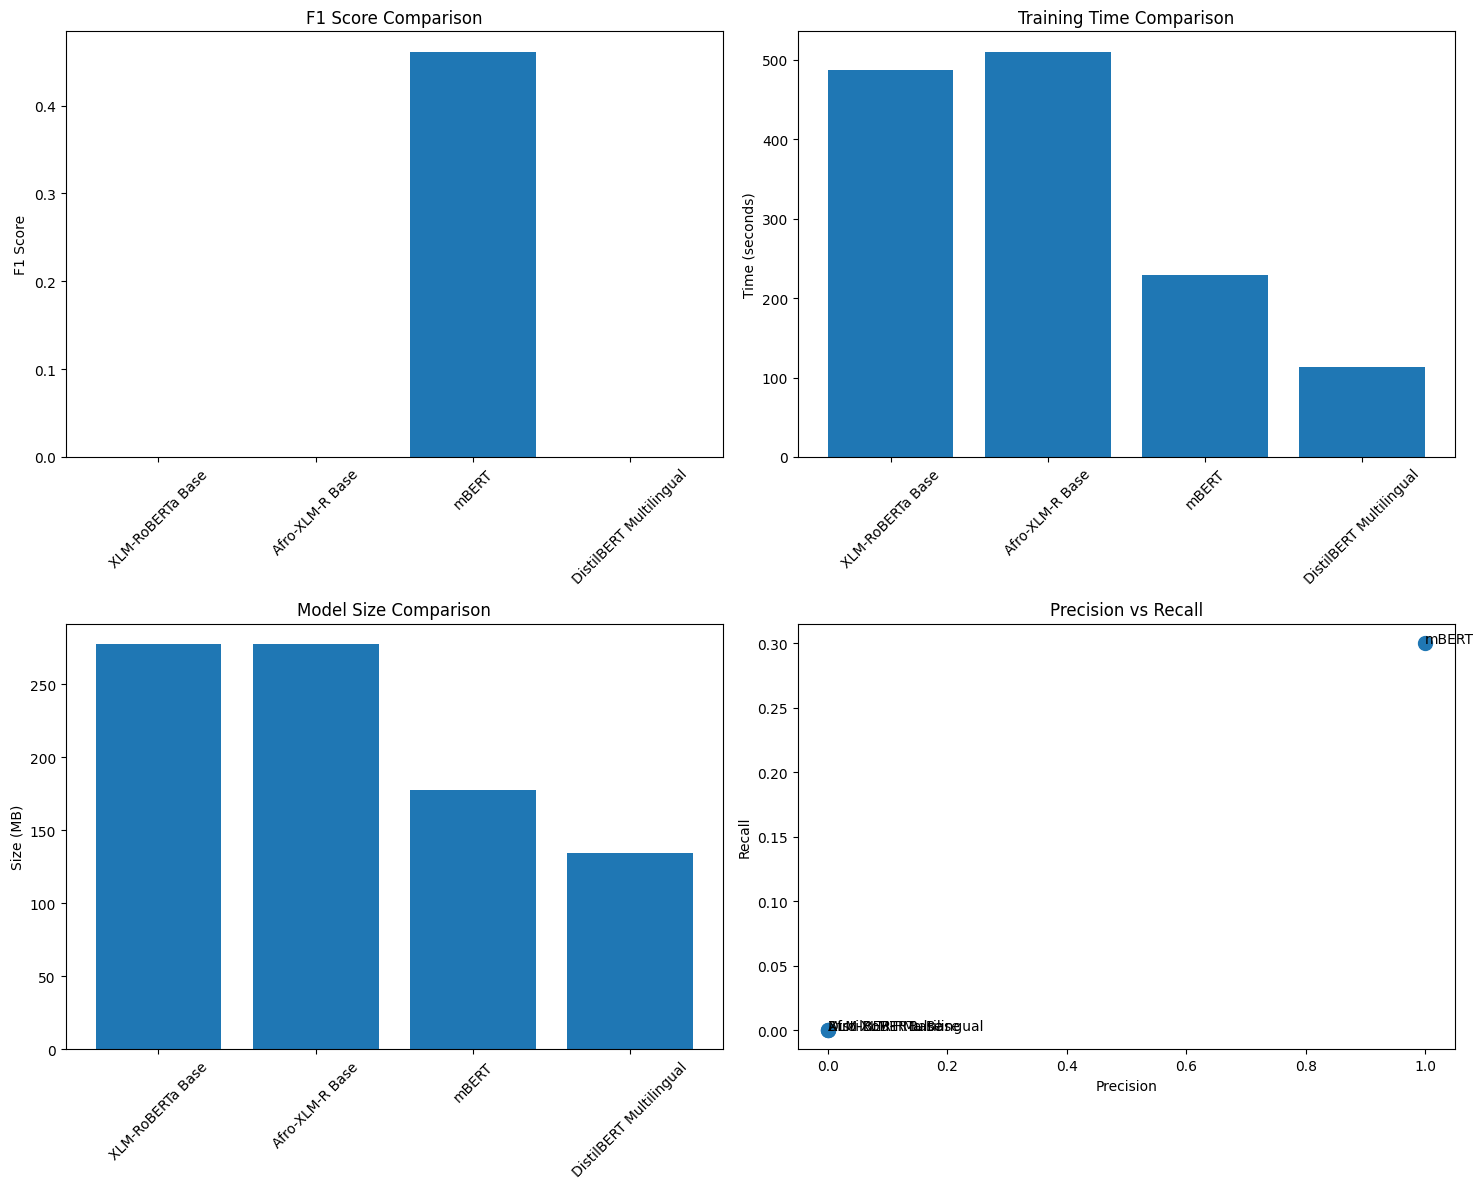


MODEL COMPARISON RESULTS
             model_name  eval_f1  eval_precision  eval_recall  eval_accuracy  training_time  model_size_mb
       XLM-RoBERTa Base   0.0000             0.0          0.0         0.9524       486.7414       277.4569
        Afro-XLM-R Base   0.0000             0.0          0.0         0.9524       510.5308       277.4569
                  mBERT   0.4615             1.0          0.3         0.9667       228.6600       177.2667
DistilBERT Multilingual   0.0000             0.0          0.0         0.9524       113.0594       134.7379

🏆 BEST MODEL: mBERT
F1 Score: 0.4615
Precision: 1.0000
Recall: 0.3000
✅ Model comparison results saved to /content/model_comparison_results/model_comparison_results.csv

✨ Summary of Best Model ✨
Model Name: mBERT
Checkpoint: bert-base-multilingual-cased
Description: Multilingual BERT, widely used for NER
Evaluation F1 Score: 0.4615
Evaluation Precision: 1.0000
Evaluation Recall: 0.3000
Evaluation Accuracy: 0.9667
Training Time (s): 2

In [13]:
# FIXED VERSION FOR GOOGLE COLAB
# Copy this entire block into a new Colab cell

def analyze_results_fixed(results):
    """Fixed version of analyze_results that handles empty results"""

    # Check if results is empty
    if not results:
        print("❌ No results to analyze! Results dictionary is empty.")
        print("Make sure you've trained at least one model successfully.")
        return None, None

    # Debug: Print what we have
    print(f"📊 Results keys: {list(results.keys())}")
    print(f"📊 Number of models: {len(results)}")

    # Convert results to DataFrame
    df = pd.DataFrame(list(results.values()))

    # Debug: Print DataFrame info
    print(f"�� DataFrame columns: {list(df.columns)}")
    print(f"�� DataFrame shape: {df.shape}")

    # Check if we have the required columns
    if 'model_name' not in df.columns:
        print("❌ 'model_name' column not found!")
        print(f"Available columns: {list(df.columns)}")
        return None, None

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # F1 Score comparison
    axes[0,0].bar(df['model_name'], df['eval_f1'])
    axes[0,0].set_title('F1 Score Comparison')
    axes[0,0].set_ylabel('F1 Score')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Training time comparison
    axes[0,1].bar(df['model_name'], df['training_time'])
    axes[0,1].set_title('Training Time Comparison')
    axes[0,1].set_ylabel('Time (seconds)')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Model size comparison
    axes[1,0].bar(df['model_name'], df['model_size_mb'])
    axes[1,0].set_title('Model Size Comparison')
    axes[1,0].set_ylabel('Size (MB)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Precision vs Recall
    axes[1,1].scatter(df['eval_precision'], df['eval_recall'], s=100)
    for i, model in enumerate(df['model_name']):
        axes[1,1].annotate(model, (df['eval_precision'].iloc[i], df['eval_recall'].iloc[i]))
    axes[1,1].set_xlabel('Precision')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].set_title('Precision vs Recall')

    plt.tight_layout()
    plt.show()

    # Print detailed comparison table
    print("\n" + "="*80)
    print("MODEL COMPARISON RESULTS")
    print("="*80)

    comparison_table = df[['model_name', 'eval_f1', 'eval_precision', 'eval_recall',
                          'eval_accuracy', 'training_time', 'model_size_mb']].round(4)
    print(comparison_table.to_string(index=False))

    # Select best model based on F1 score
    best_model = df.loc[df['eval_f1'].idxmax()]
    print(f"\n🏆 BEST MODEL: {best_model['model_name']}")
    print(f"F1 Score: {best_model['eval_f1']:.4f}")
    print(f"Precision: {best_model['eval_precision']:.4f}")
    print(f"Recall: {best_model['eval_recall']:.4f}")

    return df, best_model

# Now run the fixed analysis
print("🔍 Checking your results...")
print(f"Number of results in comparator: {len(comparator.results)}")
print(f"Results keys: {list(comparator.results.keys())}")

# Run the fixed analysis
results_df, best_model = analyze_results_fixed(comparator.results)

# If you have results, save them
if results_df is not None and best_model is not None:
    save_best_model_and_results(best_model, results_df)
else:
    print("❌ Cannot save results - no successful model training found.")
    print("💡 Try running the model training cells again.")